In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier
from source import downsample_binary, my_tokenizer
import joblib


In [3]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

In [4]:
df = pd.read_pickle("../data/reviews_vector_1_and_2grams.pkl")

In [5]:
df.duplicated(subset=df.columns[5:]).sum()

37878

In [6]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
test_later = X_test

In [8]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

In [9]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [10]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]

In [ ]:

random_forest_model = RandomForestClassifier(n_estimators=30, random_state=42) 
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

In [ ]:
tree_depths = [tree.get_depth() for tree in random_forest_model.estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 636
Minimum depth in any tree: 445
Average depth across all trees: 536.7


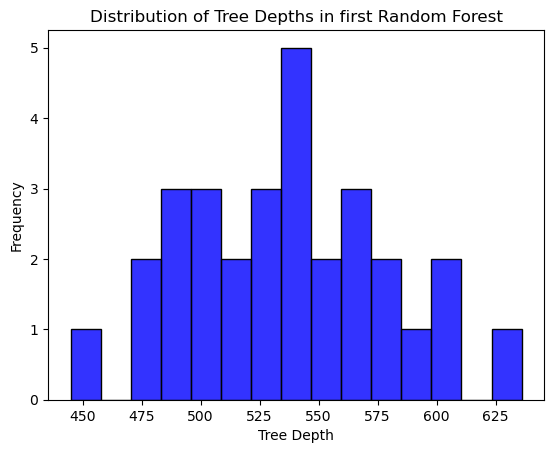

In [42]:
sns.histplot(tree_depths, alpha=0.8, color='blue', bins=15)
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')
plt.title('Distribution of Tree Depths in first Random Forest')
plt.show()

In [10]:
y_train_predicted = random_forest_model.predict(X_train_transformed)
y_test_predicted = random_forest_model.predict(X_test_transformed)
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.75      0.58      0.65     33858
           1       0.88      0.94      0.91    108374

    accuracy                           0.85    142232
   macro avg       0.81      0.76      0.78    142232
weighted avg       0.85      0.85      0.85    142232



In [ ]:
estimators = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe = Pipeline(estimators)

params = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2, cv=3)
fitted_forest = grid_search.fit(X_train, y_train)

In [24]:
estimators_bal = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe_bal = Pipeline(estimators_bal)

params_bal = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2, cv=3)
fitted_forest_bal = grid_search_bal.fit(X_train_bal, y_train_bal)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 2/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=60, model__random_state=42, normalise=StandardScaler();, score=0.813 total time= 1.2min
[CV 1/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=60, model__random_state=42, normalise=StandardScaler();, score=0.811 total time= 1.2min
[CV 3/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=60, model__random_state=42, normalise=StandardScaler();, score=0.813 total time= 1.2min
[CV 1/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=80, model__random_state=42, normalise=StandardScaler();, score=0.812 total time= 1.6min
[CV 2/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=80, model__random_state=42, normalise=StandardScaler();, score=0.814 total time= 1.6min
[CV 3/3] END model__criterion=entropy, model__max_depth=300, model__n_estimators=80, model__ran

In [26]:
fitted_forest_bal.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=600,
                                        n_estimators=80, random_state=42))])

In [11]:

estimators_f = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=60, max_depth=300,random_state=42))]
pipe_final = Pipeline(estimators_f)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x175a9d160>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x175a9d160>))])),
                ('model',
                 RandomForestClassifier(max_depth=300, n_estimators=60,
                                        random_state=42))])

In [17]:
tree_depths = [tree.get_depth() for tree in pipe_final[-1].estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 300
Minimum depth in any tree: 300
Average depth across all trees: 300.0


In [78]:
y_train_pred_f = pipe_final.predict(X_train)
y_test_pred_f = pipe_final.predict(X_test) 
y_pred_f = pipe_final.predict(X)

In [15]:

estimators_f_bal = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=80, max_depth=600,random_state=42))]
pipe_final_bal = Pipeline(estimators_f_bal)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x175a9d160>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x175a9d160>))])),
                ('model',
                 RandomForestClassifier(max_depth=600, n_estimators=80,
                                        random_state=42))])

In [16]:
joblib.dump(pipe_final, "../model/random-forest-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/random-forest-bal-model.pkl")



['../model/random-forest-bal-model.pkl']

In [79]:
y_train_pred_f_bal = pipe_final_bal.predict(X_train_bal)
y_test_pred_f_bal = pipe_final_bal.predict(X_test) 
y_pred_f_bal = pipe_final_bal.predict(X)

In [80]:
cm = confusion_matrix(y_test, y_test_pred_f)
cm_norm = confusion_matrix(y_test, y_test_pred_f, normalize="true")
cm_full = confusion_matrix(y, y_pred_f)
cm_full_norm = confusion_matrix(y, y_pred_f, normalize="true")

In [81]:
cm_bal = confusion_matrix(y_test, y_test_pred_f_bal)
cm_norm_bal = confusion_matrix(y_test, y_test_pred_f_bal, normalize="true")
cm_full_bal = confusion_matrix(y, y_pred_f_bal)
cm_full_norm_bal = confusion_matrix(y, y_pred_f_bal, normalize="true")

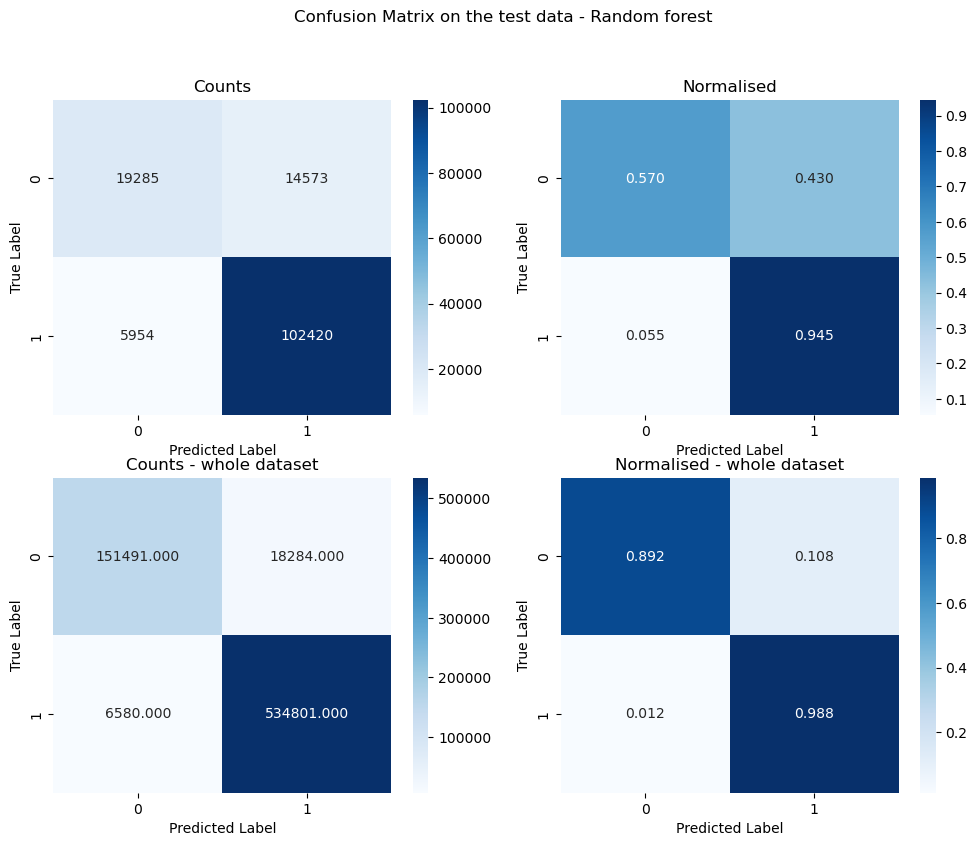

In [82]:
plt.subplots(2,2, figsize=(12, 9))
plt.subplot(2,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(2,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.subplot(2,2,3)
sns.heatmap(cm_full, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts - whole dataset")
plt.subplot(2,2,4)
sns.heatmap(cm_full_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised - whole dataset")
plt.suptitle("Confusion Matrix on the test data - Random forest")
plt.show()


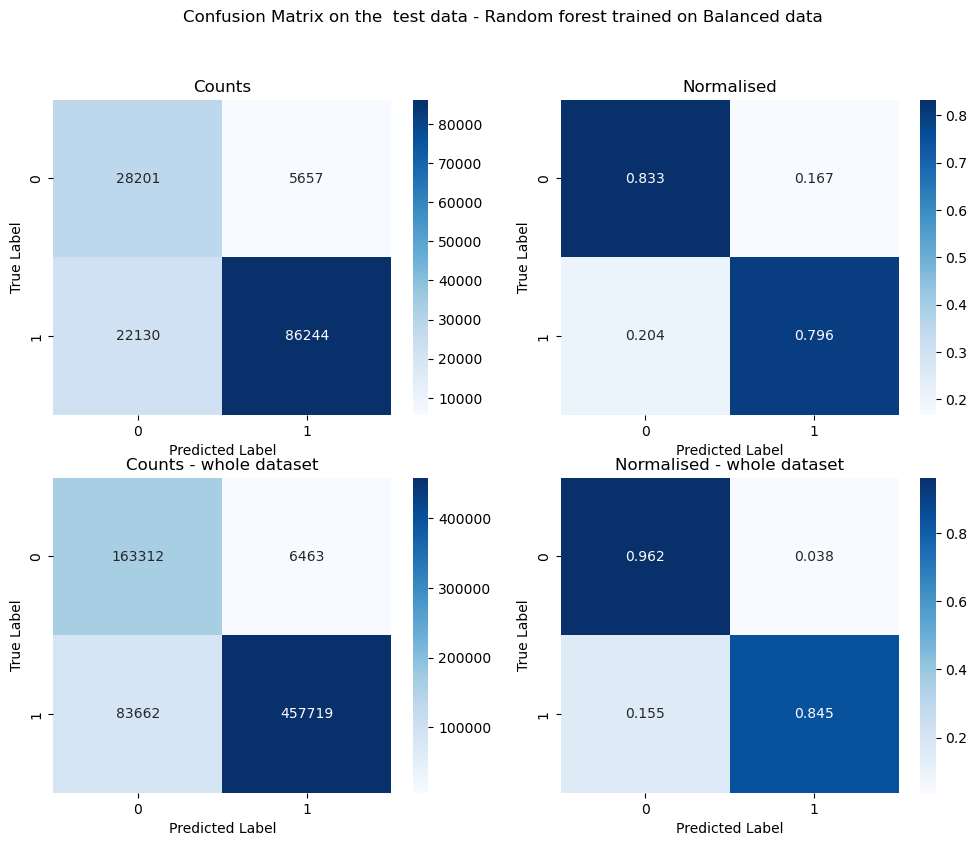

In [83]:
plt.subplots(2,2, figsize=(12, 9))
plt.subplot(2,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(2,2,2)
sns.heatmap(cm_norm_bal, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Confusion Matrix on the  test data - Random forest trained on Balanced data")
plt.subplot(2,2,3)
sns.heatmap(cm_full_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts - whole dataset")
plt.subplot(2,2,4)
sns.heatmap(cm_full_norm_bal, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised - whole dataset")
plt.show()


In [84]:
print(classification_report(y_test, y_test_pred_f))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     33858
           1       0.88      0.95      0.91    108374

    accuracy                           0.86    142232
   macro avg       0.82      0.76      0.78    142232
weighted avg       0.85      0.86      0.85    142232



In [86]:
print(classification_report(y_test, y_test_pred_f_bal))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67     33858
           1       0.94      0.80      0.86    108374

    accuracy                           0.80    142232
   macro avg       0.75      0.81      0.77    142232
weighted avg       0.85      0.80      0.82    142232



In [85]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test)

In [89]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [90]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


In [1]:
%config InlineBackend.figure_format="retina"
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced LogReg (AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced LogReg (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regreession perfoms well with both balanced and unbalanced data')
plt.legend()


plt.show()

NameError: name 'plt' is not defined

In [ ]:


# # fitting AdaBoost model with 20 estimators
# abc_2 = AdaBoostClassifier(n_estimators=20)
# abc_2.fit(X_train_transformed_bal, y_train_bal)

# # evaluate
# y_pred_ada = abc_2.predict(X_test_transformed_bal)
# print(classification_report(y_test, y_pred_ada))

In [ ]:
y_pred_baseline= random_forest_model.predict(scaler.transform(df[df.columns[5:]]))

incorrect_guesses = df["binary"] != y_pred_baseline
incorrect_v = pd.Series(y_pred_baseline)[incorrect_guesses]
ig = pd.concat([pd.Series(incorrect_v),df[incorrect_guesses]], axis=1)
ig

,0,overall,reviewText,length,binary,10,abl,absolut,access,actual,...,worri,worth,would,would buy,would recommend,wouldnt,wrong,year,yet,your
58,0,4.0,The case is pretty and looks closely to the on...,434,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,1,3.0,"Great product, works very good with no issue",44,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,0,5.0,It work properly for my sister,30,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,0,4.0,umm ok,6,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,1,2.0,Better off buying an authentic charger. Packag...,127,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717720,1,3.0,Nice phone looks like new but did not come in ...,124,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717727,1,2.0,junk if you ask me.,19,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717745,1,1.0,simply horrid,13,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717755,1,3.0,Fits perfectly on my s6,23,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
rev = ig.loc[98]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:47]} \n{text[47: ]}")

Actual: 0, Guess: 1, Overall: 3
Review: Great product, works very good with no issue 



In [ ]:
feature_values = scaler.transform(ig.loc[2, df.columns[5:]].values.reshape(1, -1))
fi = random_forest_model.feature_importances_
fi.reshape(1,-1).shape

feature_contributions = pd.DataFrame(fi.reshape(1,-1), columns=X.columns, index=['Contribution']).T
sorted_contributions = feature_contributions.sort_values(by='Contribution', ascending=False)

print(sorted_contributions.head(10))